# Contingency analysis

We can define N-1 cases to be analysed as contingencies. This means that indices of net.line, net.trafo, net.trafo3w can be defined as contingencies, which are switched off one at a time. The power system is analyzed with power flow calculations, and the min/max values among all the N-1 cases are obtained for relevant variables.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import pandapower as pp
import pandapower.contingency
import pandapower.control
import pandapower.timeseries

In [2]:
net = pp.networks.case9()

nminus1_cases = {"line": {"index": net.line.index.values}}
res = pp.contingency.run_contingency(net, nminus1_cases)

In [3]:
element_limits = pp.contingency.get_element_limits(net)
pp.contingency.check_elements_within_limits(element_limits, res, True)

False

In [4]:
pp.contingency.report_contingency_results(element_limits, res)

hp.pandapower.contingency.contingency - INFO: bus: min_vm_pu violation at index [8] ([0.794])


## Time-series simulation

The function _run_contingency_ can be passed to _run_timeseries_.

In [5]:
load_profiles = pd.DataFrame(net.load.p_mw.values * (np.random.random((24, len(net.load))) * 0.4 + 0.8), 
                             index=np.arange(24), columns=net.load.index.values)
dsl = pp.timeseries.DFData(load_profiles)
pp.control.ConstControl(net, element="load", variable="p_mw", element_index=net.load.index.values, 
                        profile_name=net.load.index.values, data_source=dsl)


gen_profiles = pd.DataFrame(net.gen.p_mw.values * (np.random.random((24, len(net.gen))) * 0.4 + 0.8), 
                             index=np.arange(24), columns=net.gen.index.values)
dsg = pp.timeseries.DFData(gen_profiles)
pp.control.ConstControl(net, element="gen", variable="p_mw", element_index=net.gen.index.values, 
                        profile_name=net.gen.index.values, data_source=dsg)

ow = pp.timeseries.OutputWriter(net)
ow.log_variable("res_line", "max_loading_percent")
ow.log_variable("res_line", "min_loading_percent")
ow.log_variable("res_bus", "max_vm_pu")
ow.log_variable("res_bus", "min_vm_pu")

In [6]:
pp.timeseries.run_timeseries(net, time_steps=range(24), run=pp.contingency.run_contingency, nminus1_cases=nminus1_cases)

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:02<00:00, 11.90it/s]


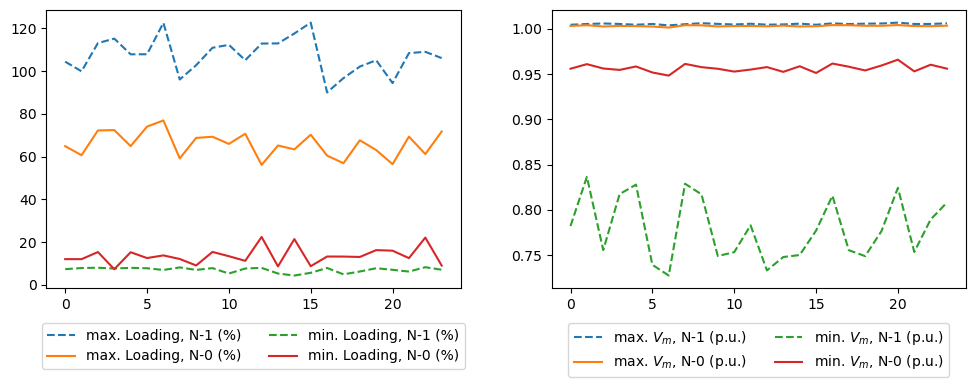

In [7]:
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(10,4))
ow.output["res_line.max_loading_percent"].max(axis=1).plot(label="max. Loading, N-1 (%)", ax=ax1, linestyle="--")
ow.output["res_line.loading_percent"].max(axis=1).plot(label="max. Loading, N-0 (%)", ax=ax1)
ow.output["res_line.min_loading_percent"].min(axis=1).plot(label="min. Loading, N-1 (%)", ax=ax1, linestyle="--")
ow.output["res_line.loading_percent"].min(axis=1).plot(label="min. Loading, N-0 (%)", ax=ax1)
ax1.legend(ncol=2, loc="upper center", bbox_to_anchor=[0.5, -0.1])
ow.output["res_bus.max_vm_pu"].max(axis=1).plot(label="max. $V_m$, N-1 (p.u.)", ax=ax2, linestyle="--")
ow.output["res_bus.vm_pu"].max(axis=1).plot(label="max. $V_m$, N-0 (p.u.)", ax=ax2)
ow.output["res_bus.min_vm_pu"].min(axis=1).plot(label="min. $V_m$, N-1 (p.u.)", ax=ax2, linestyle="--")
ow.output["res_bus.vm_pu"].min(axis=1).plot(label="min. $V_m$, N-0 (p.u.)", ax=ax2)
ax2.legend(ncol=2, loc="upper center", bbox_to_anchor=[0.5, -0.1])
plt.tight_layout()

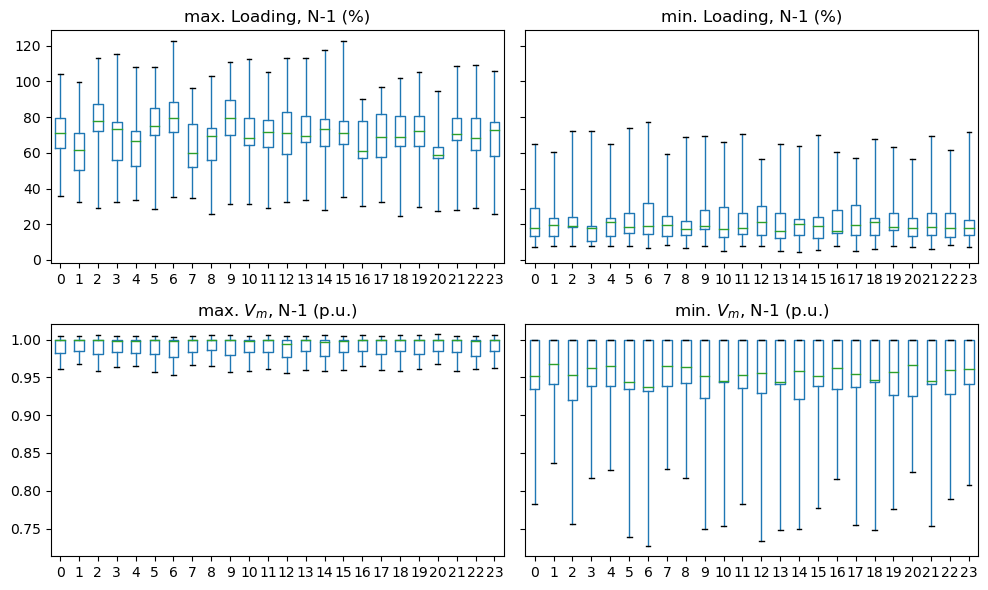

In [8]:
fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(ncols=2, nrows=2, sharey="row", figsize=(10,6))
ow.output["res_line.max_loading_percent"].T.boxplot(ax=ax11, whis=[0,100], grid=False)
ax11.set_title("max. Loading, N-1 (%)")
ow.output["res_line.min_loading_percent"].T.boxplot(ax=ax12, whis=[0,100], grid=False)
ax12.set_title("min. Loading, N-1 (%)")
ow.output["res_bus.max_vm_pu"].T.boxplot(ax=ax21, whis=[0,100], grid=False)
ax21.set_title("max. $V_m$, N-1 (p.u.)")
ow.output["res_bus.min_vm_pu"].T.boxplot(ax=ax22, whis=[0,100], grid=False)
ax22.set_title("min. $V_m$, N-1 (p.u.)")
plt.tight_layout()